In [110]:
### Step 1: Loading the Data
import pandas as pd

In [111]:
# Load the datasets
train_df = pd.read_csv(r"C:\Users\ASUS\Downloads\train.csv")
test_df = pd.read_csv(r"C:\Users\ASUS\Downloads\test.csv")
 

In [112]:
### Step 2: Exploratory Data Analysis (EDA)

#### Data Inspection
# Display the first few rows of each dataset
print(train_df.head())
print(test_df.head())



                                     LossDescription   ResultingInjuryDesc  \
0  EE while helping the children clean up after l...   Fall Or Slip Injury   
1  Clmt was putting bread trays on bottom of brea...                   NaN   
2  He got off of he forklift and did not secure p...    Motor Vehicle, NOC   
3                      slammed left finger in closet  Struck Or Injured By   
4  the employee was digging a tre; strain; lower ...                   NaN   

                            PartInjuredDesc  \
0                         Lower Extremities   
1                                       NaN   
2  Foot-Metatarsals, Heel excl Ankle or Toe   
3                         Upper Extremities   
4                                       NaN   

                                 Cause - Hierarchy 1 Body Part - Hierarchy 1  \
0                          Fall, Slip or Trip Injury       Lower Extremities   
1  Burn or Scald - Heat or Cold Exposures - Conta...                    Neck   
2       

In [113]:
# Get summary information
train_df.info()
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   LossDescription          3886 non-null   object
 1   ResultingInjuryDesc      2489 non-null   object
 2   PartInjuredDesc          1922 non-null   object
 3   Cause - Hierarchy 1      3892 non-null   object
 4   Body Part - Hierarchy 1  3659 non-null   object
 5   Index                    3918 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 183.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LossDescription          432 non-null    object 
 1   ResultingInjuryDesc      273 non-null    object 
 2   PartInjuredDesc          228 non-null    object 
 3   Cause - Hierarchy 1      0 non-null    

In [119]:

# Clean the Data
# Update the values of 'Cause - Hierarchy 1' to lower case
train_df['Cause - Hierarchy 1'] = train_df['Cause - Hierarchy 1'].str.lower()
train_df['Cause - Hierarchy 1'] = train_df['Cause - Hierarchy 1'].str.replace(',', "")
# Delete rows with missing values in either 'Cause - Hierarchy 1', 'Body Part - Hierarchy 1', or 'LossDescription'
train_df.dropna(subset=['Cause - Hierarchy 1', 'Body Part - Hierarchy 1', 'LossDescription'], inplace=True)




In [136]:
#### Handling Missing Data
# Impute missing values for specific columns with the most frequent category
for column in ['LossDescription', 'Cause - Hierarchy 1', 'Body Part - Hierarchy 1']:
    train_df[column].fillna(train_df[column].mode()[0], inplace=True)
    


In [137]:
# Encode missing values in certain columns as 'Unknown'
for column in ['ResultingInjuryDesc', 'PartInjuredDesc']:
    train_df[column].fillna('Unknown', inplace=True)




In [138]:
#### Visualizing the Distribution of Target Variables
import matplotlib.pyplot as plt
import seaborn as sns


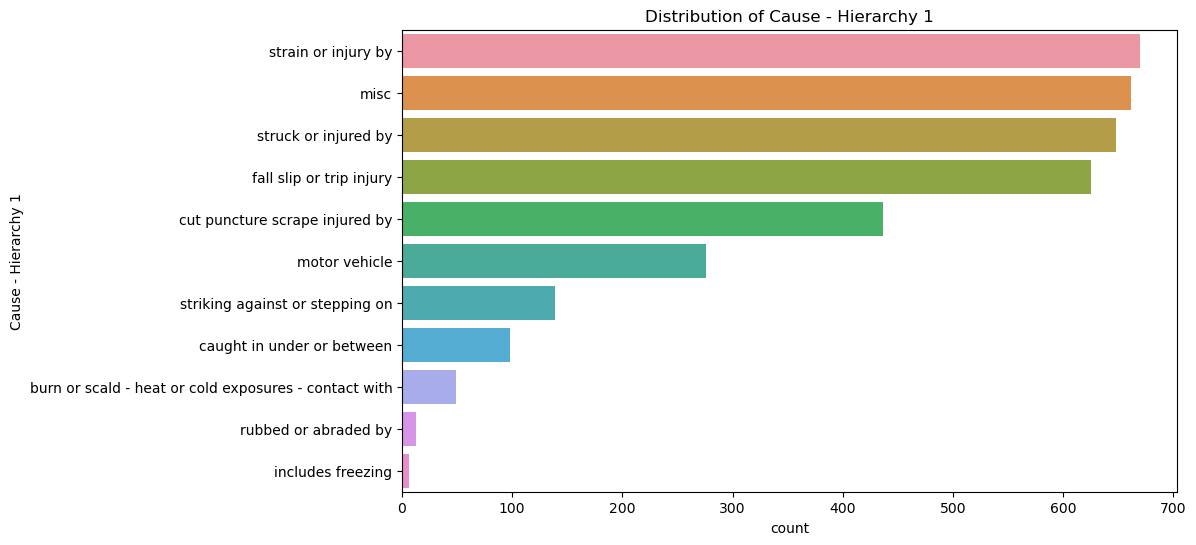

In [139]:
# Visualization for 'Cause - Hierarchy 1'

plt.figure(figsize=(10, 6))
sns.countplot(y='Cause - Hierarchy 1', data=train_df, order=train_df['Cause - Hierarchy 1'].value_counts().index)
plt.title('Distribution of Cause - Hierarchy 1')
plt.show()




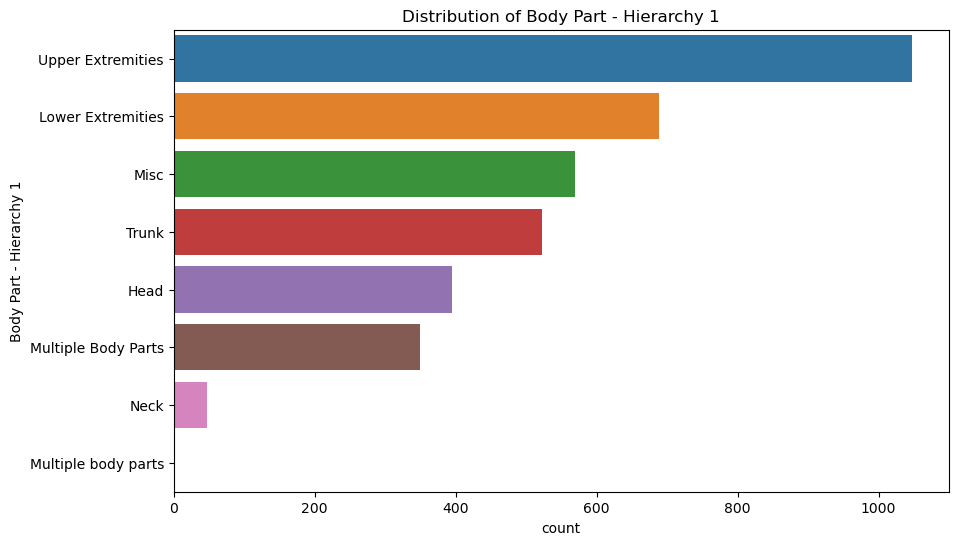

In [140]:
# Visualization for 'Body Part - Hierarchy 1'
plt.figure(figsize=(10, 6))
sns.countplot(y='Body Part - Hierarchy 1', data=train_df, order=train_df['Body Part - Hierarchy 1'].value_counts().index)
plt.title('Distribution of Body Part - Hierarchy 1')
plt.show()


In [141]:
### Text Data Analysis

#### Word Cloud for "LossDescription"

from wordcloud import WordCloud

In [142]:
# Convert 'LossDescription' column to string
train_df['LossDescription'] = train_df['LossDescription'].astype(str)

# Combine all text for LossDescription
all_text = ' '.join(train_df['LossDescription'].values)



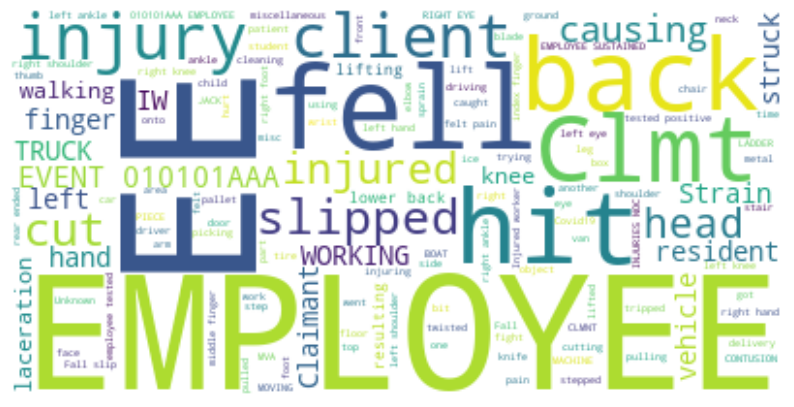

In [143]:
# Generate and display a word cloud

wordcloud = WordCloud(background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [144]:
#### Bigram Analysis
from sklearn.feature_extraction.text import CountVectorizer

In [145]:
# Extract bigrams and count their frequencies

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X2 = vectorizer.fit_transform(train_df['LossDescription'])
sums = X2.sum(axis=0)
bigrams = [(bigram, sums[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]
sorted_bigrams = sorted(bigrams, key=lambda x: x[1], reverse=True)


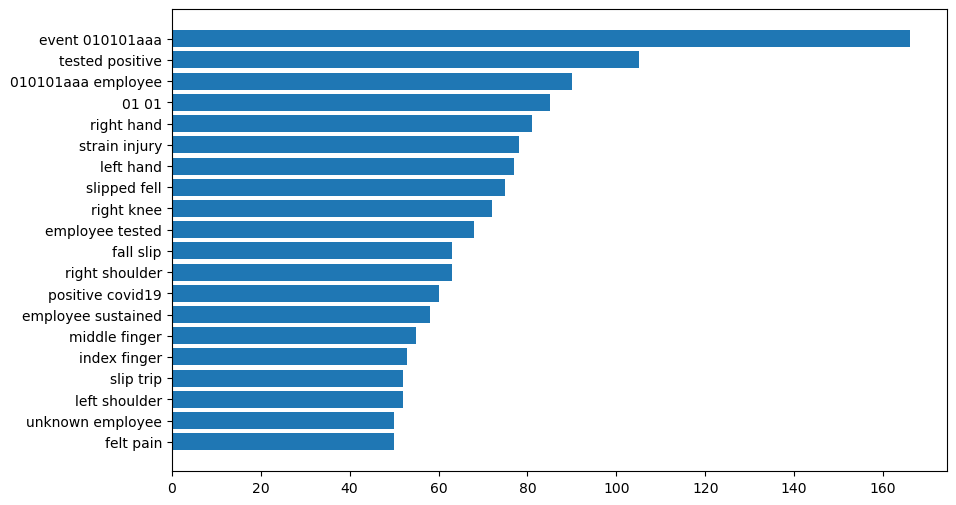

In [146]:
# Plot the top 20 bigrams
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_bigrams)), [val[1] for val in sorted_bigrams], align='center')
plt.yticks(range(len(sorted_bigrams)), [val[0] for val in sorted_bigrams])
plt.gca().invert_yaxis()
plt.show()


In [147]:
#### Preprocessing Text Data with TF-IDF Vectorization and Encoding Categorical Variables

from sklearn.feature_extraction.text import TfidfVectorizer

text_feature = 'LossDescription'
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)

In [148]:
# Preparing the dataset (an example for one target variable)
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['ResultingInjuryDesc', 'PartInjuredDesc']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')





In [149]:
# Splitting the dataset into training and validation sets
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_feature),
        ('cat', categorical_transformer, categorical_features)
    ])


In [150]:
# Setting up preprocessing for categorical variables

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline_cause = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_body_part = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [151]:
# Setting up preprocessing for text variables
from sklearn.model_selection import train_test_split

X = train_df.drop(['Cause - Hierarchy 1', 'Body Part - Hierarchy 1', 'Index'], axis=1)
y_cause = train_df['Cause - Hierarchy 1']
y_body_part = train_df['Body Part - Hierarchy 1']

X_train, X_val, y_cause_train, y_cause_val = train_test_split(X, y_cause, test_size=0.2, random_state=42)
_, _, y_body_part_train, y_body_part_val = train_test_split(X, y_body_part, test_size=0.2, random_state=42)

In [152]:
# Train models
pipeline_cause.fit(X_train, y_cause_train)
pipeline_body_part.fit(X_train, y_body_part_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'LossDescription'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ResultingInjuryDesc',
                                                   'PartInjuredDesc'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [153]:
### Model Evaluation Code Snippet

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Calculating evaluation metrics
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    # Printing evaluation metrics
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred, average='weighted'):.4f}")
    print(f"F1: {f1_score(y_val, y_pred, average='weighted'):.4f}")
    print(classification_report(y_val, y_pred))

In [154]:
print("Cause - Hierarchy 1 Model Evaluation:")
evaluate_model(pipeline_cause, X_val, y_cause_val)

print("\nBody Part - Hierarchy 1 Model Evaluation:")
evaluate_model(pipeline_body_part, X_val, y_body_part_val)

Cause - Hierarchy 1 Model Evaluation:
Accuracy: 0.7531
Precision: 0.7511
Recall: 0.7531
F1: 0.7466
                                                       precision    recall  f1-score   support

burn or scald - heat or cold exposures - contact with       0.75      0.50      0.60         6
                           caught in under or between       0.67      0.53      0.59        15
                       cut puncture scrape injured by       0.77      0.80      0.79        96
                             fall slip or trip injury       0.78      0.83      0.80       118
                                    includes freezing       0.00      0.00      0.00         3
                                                 misc       0.66      0.78      0.72       139
                                        motor vehicle       0.82      0.73      0.77        55
                                 rubbed or abraded by       1.00      0.25      0.40         4
                                  strain or i

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classificati

In [155]:
# Impute missing values for specific columns with the most frequent category
for column in ['LossDescription', 'Cause - Hierarchy 1', 'Body Part - Hierarchy 1']:
    test_df[column].fillna(train_df[column].mode()[0], inplace=True)

# Encode missing values in certain columns as 'Unknown'
for column in ['ResultingInjuryDesc', 'PartInjuredDesc']:
    test_df[column].fillna('Unknown', inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20044\3475390141.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'strain or injury by' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df[column].fillna(train_df[column].mode()[0], inplace=True)


In [156]:
# Assuming test_df is your test DataFrame and has the same structure as train_df

# Note: Remove the 'Index' column if it's not a feature in your model
X_test = test_df

# Generate predictions
cause_hierarchy_1_preds = pipeline_cause.predict(X_test)
body_part_hierarchy_1_preds = pipeline_body_part.predict(X_test)

# Add predictions to the test DataFrame (optional)
test_df['Predicted Cause - Hierarchy 1'] = cause_hierarchy_1_preds
test_df['Predicted Body Part - Hierarchy 1'] = body_part_hierarchy_1_preds

# Output the test DataFrame with predictions
print(test_df[['Predicted Cause - Hierarchy 1', 'Predicted Body Part - Hierarchy 1']].head())

  Predicted Cause - Hierarchy 1 Predicted Body Part - Hierarchy 1
0                          misc                             Trunk
1                          misc                             Trunk
2                          misc                             Trunk
3           strain or injury by                 Lower Extremities
4          struck or injured by                 Upper Extremities
